# SaSW, Vyhľadávanie názorového spamu (disinformácie,manipulácia), rekurentná neurónová sieť
### Adam Jozefík, Matúš Harčárik

## Dáta
Dáta: https://www.kaggle.com/rtatman/deceptive-opinion-spam-corpus
Obsahuje dataset skutočných aj klamlivých recenzií hotelov s údajmi o tom, či bola recenzia klamlivá, o aký hotel sa jednalo, či išlo o pozitívnu alebo negatívnu recenziu, zdroj recenzie a text recenzie.
### Knižnice
Numpy, Pandas, Matplotlib, Sklearn, Keras, Metrics

In [42]:
# reading data, exploring and plotting
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# train test split
from sklearn.model_selection import train_test_split
# text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout
# confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### Načítanie dát

In [43]:
df=pd.read_csv('Downloads/deceptive-opinio.csv')
df

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...
...,...,...,...,...,...
1595,deceptive,intercontinental,negative,MTurk,Problems started when I booked the InterContin...
1596,deceptive,amalfi,negative,MTurk,The Amalfi Hotel has a beautiful website and i...
1597,deceptive,intercontinental,negative,MTurk,The Intercontinental Chicago Magnificent Mile ...
1598,deceptive,palmer,negative,MTurk,"The Palmer House Hilton, while it looks good i..."


#### Vymazanie nerelevantných atribútov a vytvorenie cieľového atribútu
Kedže nám ide o klasifikáciu na základe textu tak nepotrebujeme atribúty ako názov hotelu a stránka na recenzie. Cieľový atribút je kombinácia atribútov deceptive a polarity. Tieto 2 atribíty majú 4 kombinácie/triedy.

In [44]:
#vymazanie atribútov
df = df.drop(['hotel','source' ],axis = 1)
# Vytvorenie cieľového atribútu
df["label"] = df["deceptive"] + df["polarity"]
df = df.drop(['deceptive','polarity' ],axis = 1)

In [45]:
#Dáta nemajú chybajúce hodnoty
df.isnull().sum()

text     0
label    0
dtype: int64

In [46]:
df.groupby('label').describe().T

label                                        deceptivenegative  \
text count                                                 400   
     unique                                                400   
     top     My husband and I stayed at the Hotel Allegro i...   
     freq                                                    1   

label                                        deceptivepositive  \
text count                                                 400   
     unique                                                400   
     top     I frequently have business meetings in Downtow...   
     freq                                                    1   

label                                         truthfulnegative  \
text count                                                 400   
     unique                                                396   
     top     I'd been searching for a cool, non-chain hotel...   
     freq                                                    2   

label                                         truthfulpositive  
text count                                                 400  
     unique                                                400  
     top     If you want to stay in a fabulous hotel in the...  
     freq                                                    1

#### Transformácia cieľové atribútu a vytvorenie test. a trén. množniny

In [47]:
# 4 triedy cieľového atribútu sú transformované na čísla
df['label1']= df['label'].map({'deceptivenegative': 0, 'deceptivepositive': 1, 'truthfulnegative': 2, 'truthfulpositive': 3})
df = df.drop(['label' ],axis = 1)
df

,text,label1
0,We stayed for a one night getaway with family ...,3
1,Triple A rate with upgrade to view room was le...,3
2,This comes a little late as I'm finally catchi...,3
3,The Omni Chicago really delivers on all fronts...,3
4,I asked for a high floor away from the elevato...,3
...,...,...
1595,Problems started when I booked the InterContin...,0
1596,The Amalfi Hotel has a beautiful website and i...,0
1597,The Intercontinental Chicago Magnificent Mile ...,0
1598,"The Palmer House Hilton, while it looks good i...",0


In [48]:
# Rozdelenia dáta na trénovaciu a testovaciu množinu 80%/20%
train_text, test_text, train_labels, test_labels = train_test_split(df['text'], df['label1'], test_size=0.2, random_state=123)

#### Predspracovanie dáta pre potreby neurónovej siete
#### Tokenizer
Slúži na konvertovanie textu do numerickej reprezentácie. Ofiltruje interpunkčné znaky, zmení všetky znaky na málé a prevedie všetky slová na celočíselný index maximalnej zadanej dĺžky.
**max_len** - maximálna dĺžka vektora <br>
**padding_type** - Použitím PRE , doplnia sa nuly pred každou sekvenciou a použitím post doplnia sa nuly po každej sekvencii.<br>
**trunc_type** - Pre sekvencie ktoré sú dlhé tak sa hodnoty odstránia zozadu alebo z predu<br>
**vocab_size** - Označuje, koľko jedinečných slov sa má načítaťpre trénovanie a testovanie. 
**max_len** - Maximálna dĺžka číselného vektora. 

In [49]:
# Definovanie parametrov
max_len = 200
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 1500

In [50]:
# Aplikovanie tokenizácie na trénovaciu množinu
tokenizer = Tokenizer(num_words = vocab_size, char_level=False, oov_token = oov_tok)
tokenizer.fit_on_texts(train_text)

In [51]:
# Vypisánie unikátnych tokenov v dátach
training_words = len(word_index)
print('There are %s unique tokens in training data. ' % training_words)

There are 9201 unique tokens in training data. 


In [52]:
# Transformácia textu na číselné vektory, odstraňovanie znakov v príliš veľkých vektoroch a dopnenie malých vektorou nulami v testovacej a trénovacej množine
training_sequences = tokenizer.texts_to_sequences(train_text)
training_padded = pad_sequences (training_sequences, maxlen = max_len, padding = padding_type, truncating = trunc_type )
testing_sequences = tokenizer.texts_to_sequences(test_text)
testing_padded = pad_sequences(testing_sequences, maxlen = max_len,
padding = padding_type, truncating = trunc_type)

In [53]:
# Vypísanie tvaru trénovacích dát
print('Shape of training tensor: ', training_padded.shape)
print('Shape of testing tensor: ', testing_padded.shape)

Shape of training tensor:  (1280, 200)
Shape of testing tensor:  (320, 200)


### Vytvorenie architektúry neurónovej siete
Prvá vrstva je embedding vrstva na ktorá ma tvar vstupných dát  <br>
GlobalAveragePooling vrstva pomáha znižovať počet parametrov v modeli <br>
Dense vrstva s aktivačnou funkciou „relu“, po ktorej nasleduje Dropout vrstva, aby sa predišlo preučeniu, a posledná výstupná vrstva s funkciou aktivácie softmax pretože máme viacero tried <br>

In [54]:
# Veĺkosť masky neurónovej siete
embeding_dim = 16 # velkost vektora
drop_value = 0.2 # dropout
n_dense = 24

In [55]:
#Architekrtúra
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())

model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))

model.add(Dense(24, activation='relu'))
model.add(Dropout(drop_value))


model.add(Dense(4, activation='softmax'))

In [56]:
# Sumarizácia modelu
model.summary() 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 16)           24000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_2 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 24)                600       
_________________________________________________________________
dropout_3 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 4)                

In [57]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='RMSprop' ,metrics=['accuracy'])

In [58]:
# Nasadenie modelu na trénovacie dáta
num_epochs = 30
history = model.fit(training_padded, train_labels, epochs=num_epochs, validation_data=(testing_padded, test_labels))

Epoch 1/30
40/40 [==============================] - 1s 5ms/step - loss: 1.3802 - accuracy: 0.2879 - val_loss: 1.3713 - val_accuracy: 0.3250
Epoch 2/30
40/40 [==============================] - 0s 2ms/step - loss: 1.3595 - accuracy: 0.3558 - val_loss: 1.3478 - val_accuracy: 0.3750
Epoch 3/30
40/40 [==============================] - 0s 2ms/step - loss: 1.3306 - accuracy: 0.3642 - val_loss: 1.3165 - val_accuracy: 0.3969
Epoch 4/30
40/40 [==============================] - 0s 2ms/step - loss: 1.2988 - accuracy: 0.3965 - val_loss: 1.2749 - val_accuracy: 0.4187
Epoch 5/30
40/40 [==============================] - 0s 2ms/step - loss: 1.2457 - accuracy: 0.4439 - val_loss: 1.2230 - val_accuracy: 0.4250
Epoch 6/30
40/40 [==============================] - 0s 2ms/step - loss: 1.1825 - accuracy: 0.4705 - val_loss: 1.1553 - val_accuracy: 0.5500
Epoch 7/30
40/40 [==============================] - 0s 2ms/step - loss: 1.1203 - accuracy: 0.5274 - val_loss: 1.0810 - val_accuracy: 0.6125
Epoch 8/30
40/40 [==

#### Vypočítanie presnosti modelu a zobrazenie priebehu prenosti a straty na trénovaích dátach

In [59]:
# Prenosť modelu na dátach
model.evaluate(testing_padded, test_labels)

10/10 [==============================] - 0s 776us/step - loss: 0.5178 - accuracy: 0.8219


[0.5178004503250122, 0.8218749761581421]

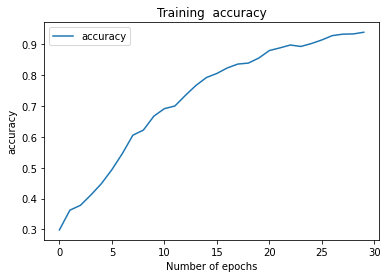

In [60]:
# Graf pre zobrazenie presností na trévacích dátach v priebehu epóch
metrics = pd.DataFrame(history.history)
metrics['accuracy'].plot()
plt.title('Training  accuracy')
plt.xlabel ('Number of epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy'])

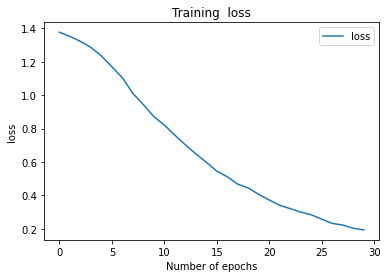

In [61]:
# Graf pre zobrazenie loss na trévacích dátach v priebehu epóch
metrics = pd.DataFrame(history.history)
metrics['loss'].plot()
plt.title('Training  loss')
plt.xlabel ('Number of epochs')
plt.ylabel('loss')
plt.legend(['loss'])

#### Porovnanie klasifíkacie na jednotlivých triedach pomocou kontingenčnej matice a presností pre jednotlivé triedy 
**deceptivenegative** - 0<br>
**deceptivepositive** - 1<br>
**truthfulnegativ** - 2<br>
**truthfulpositive** - 3

In [62]:
predictions = model.predict(testing_padded[:10000])

#### Kontingenčná tabuľka

In [63]:
array_pred = []
for i in range(320):
    array_pred.append(np.argmax(predictions[i]))
matrix =confusion_matrix(test_labels, array_pred ,labels=[0,1,2,3])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[59  1 19  1]
 [ 1 73  0  7]
 [ 9  0 70  8]
 [ 1  9  1 61]]


#### Porovnanie jendotlivých tried

In [64]:
matrix = classification_report(test_labels, array_pred ,labels=[0 ,1,2,3])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.84      0.74      0.79        80
           1       0.88      0.90      0.89        81
           2       0.78      0.80      0.79        87
           3       0.79      0.85      0.82        72

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320



### Optimalizácia neurónovej siete
Obsahuje zmeny vykonané pre zvýšenie presnoti neurónovej sieti<br>
Najlepšie výsledky mali vrstvy s počtom neurónou okolo 24.<br>
Najvyššia presnoť pri klasifikácií bola pri triede deceptivenegative

| Iterácia | Počet vnútorných vrstiev|epochs |Accuracy |Optimalizátor|poznámka|
| ---  | --- | ---| ---| ---|-- |
| 1 |1 |5 |0.5625|adam |Prvá iterácia |
| 2 |1 |20 |0.7531|adam |Pridanie epoch na 20 |
| 3 |1 |30 |0.7563|adam |Zvýšenie epoch na 30 |
| 4 |2 |30 |0.7344|adam |Pridanie vrtvy do neurónovej sieti |
| 5 |1 |30 |0.7469|RMSprop |Zmena optimalizačnej metódy |
| 6 |2 |30 |0.7594|RMSprop|Pridanie vrtvy do neurónovej sieti s RMSprop |
| 7 |3 |30 |0.5188|RMSprop |-- |
| 8 |2 |30 |0.2937|Adagrad |Zmena optimalizačnej metódy |
| 9 |2 |30 |0.7688|RMSprop|Zvýšil som veľkosť unikátnych slov v slovníku a veľkosť vektorá  |
| 10 |2 |30 |0.8219|RMSprop|Zvýšil som veľkosť unikátnych slov v slovníku a veľkosť vektorá  na maximálnu|


### Najlepšie nastavenie parametrov pri maximálnej dľžke vektora a slovníka : <br>

| Iterácia | Počet vnútorných vrstiev|epochs |Accuracy |Optimalizátor|
| ---  | --- | ---| ---| ---|
| 10 |2 |30 |0.8219|RMSprop|

